In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import random
import time

# Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate, get_device
from util.data_utilities import get_base_tensor_directories, generate_batch, get_train_and_val_loader, process_data

# import all the models from models module
from models import CNN3DClassifier

device = get_device()

You are using device: cpu


In [2]:
# process_data(
#     input_type='video_pack_1000', 
#     # addition_parameters={'first_n_videos': 5}, 
#     verbose=False,
#     device=get_device(),
#     skip_frames=True,
#     frames_to_skip=200,
#     resize_tensors=True,
#     # uniform_frames=True,
#     # set_frame_count=15,
#     shrink=8,
#     clean_dir=True
# )

In [3]:
device = get_device()
train_loader, val_loader = get_train_and_val_loader(
    input_type='video_pack_1000',
    batch_size=15,
    verbose=True,
    tensor_upper_limit=1000,
    target_type='classification'
)

You are using device: cpu


torch.Size([3, 2, 128, 72])
torch.Size([3, 15, 128, 72])
800
200


In [5]:
model = CNN3DClassifier(
    reduce_pool=8,
    filters=15,
    depth=30,
    dropout_rate=0.1
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.9)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

EPOCHS = 20

train_losses = []
val_losses = []

input_verbose = False


Total parameters: 1,666,204


In [6]:
start_time = time.time()

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = train(model, train_loader, criterion, optimizer, device, verbose=input_verbose)
    val_loss, avg_val_loss = evaluate(model, val_loader, criterion, device, verbose=input_verbose)
    
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = 1
    if ((epoch+1) % num == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')


In [6]:
# save model if better or not exists
model_weights = {'model_state_dict': model.state_dict(), 'val_loss': avg_val_loss}
weights_file = '../models/save/CNN_classifier_weights.pt'
if not os.path.isfile(weights_file):
    # save new
    torch.save(model_weights, weights_file)
elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
    # replace
    torch.save(model_weights, weights_file)

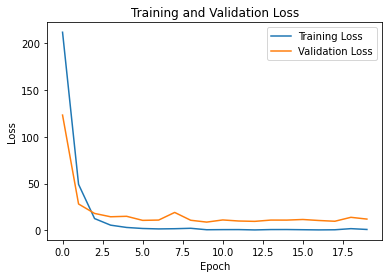

In [7]:
import matplotlib.pyplot as plt

# lost plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:
# compare to validation set
val_values = []
predicted_values = []

for inputs, targets in val_loader:
    inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)

    # Forward pass
    outputs = model(inputs)

    # Append the values
    val_values.extend(targets.tolist())
    predicted_values.extend(outputs.tolist())

In [9]:
import numpy as np

In [10]:
predicted_classes, true_classes = [], []
for i in range(len(predicted_values)):
    predicted_values_i = predicted_values[i]
    val_values_1 = val_values[i]

    prediction_prob = torch.nn.functional.softmax((torch.from_numpy(np.array(predicted_values_i))), dim=0)
    predicted_class = prediction_prob.argmax(dim=0).item()
    true_class = np.argmax(np.array(val_values_1))

    print(f'predicted class: {predicted_class}, true class: {true_class}')
    print(f'prediction prob: {prediction_prob}\n\n')

    predicted_classes.append(predicted_class)
    true_classes.append(true_class)


predicted class: 0, true class: 1
prediction prob: tensor([1.0000e+00, 5.6219e-53, 3.3926e-30, 4.9526e-42], dtype=torch.float64)


predicted class: 0, true class: 1
prediction prob: tensor([9.8072e-01, 7.1542e-03, 1.1825e-02, 2.9652e-04], dtype=torch.float64)


predicted class: 0, true class: 1
prediction prob: tensor([5.9102e-01, 3.0883e-01, 9.9638e-02, 5.1424e-04], dtype=torch.float64)


predicted class: 0, true class: 1
prediction prob: tensor([0.7161, 0.0354, 0.1968, 0.0517], dtype=torch.float64)


predicted class: 2, true class: 2
prediction prob: tensor([5.5719e-10, 7.9151e-05, 9.9992e-01, 3.3013e-14], dtype=torch.float64)


predicted class: 0, true class: 2
prediction prob: tensor([9.9370e-01, 1.5891e-06, 3.8139e-10, 6.2944e-03], dtype=torch.float64)


predicted class: 2, true class: 2
prediction prob: tensor([3.8903e-03, 7.2594e-46, 9.9611e-01, 3.9050e-28], dtype=torch.float64)


predicted class: 2, true class: 1
prediction prob: tensor([2.8517e-01, 4.6309e-04, 7.0800e-01, 6.36

In [11]:
predicted_classes = torch.from_numpy(np.array(predicted_classes))
true_classes = torch.from_numpy(np.array(true_classes))

In [12]:
((predicted_classes == true_classes).sum() / true_classes.shape[0]).item()

0.20999999344348907

In [18]:
true_classes.numpy()

array([1, 1, 1, 1, 2, 2, 2, 1, 3, 3, 1, 2, 1, 0, 1, 1, 2, 2, 1, 0, 3, 0,
       3, 2, 1, 0, 0, 3, 1, 2, 2, 3, 0, 2, 0, 2, 1, 0, 1, 0, 2, 0, 1, 2,
       2, 2, 2, 1, 0, 1, 2, 1, 1, 1, 0, 1, 0, 3, 2, 1, 3, 0, 0, 2, 2, 3,
       0, 2, 0, 0, 3, 0, 0, 1, 3, 0, 1, 2, 2, 2, 1, 2, 2, 1, 3, 3, 2, 2,
       1, 2, 3, 3, 1, 0, 1, 1, 3, 1, 2, 2, 1, 2, 3, 2, 0, 3, 1, 1, 3, 2,
       3, 0, 2, 0, 2, 0, 3, 3, 2, 1, 1, 0, 1, 1, 1, 3, 3, 0, 2, 2, 1, 2,
       3, 2, 1, 2, 2, 2, 1, 0, 1, 0, 3, 1, 2, 3, 0, 2, 0, 1, 1, 1, 1, 2,
       3, 2, 3, 0, 3, 3, 2, 0, 2, 2, 3, 2, 1, 1, 3, 0, 0, 2, 0, 3, 0, 2,
       2, 0, 2, 0, 0, 0, 1, 1, 2, 1, 1, 2, 0, 0, 0, 2, 0, 1, 0, 1, 0, 3,
       2, 0])

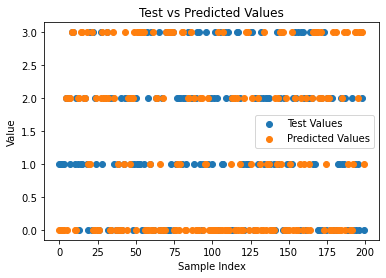

In [20]:
import matplotlib.pyplot as plt

plt.scatter(range(len(true_classes)), true_classes.numpy(), label='Test Values')
plt.scatter(range(len(true_classes)), predicted_classes.numpy(), label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test vs Predicted Values')
plt.legend()
plt.show()